<a href="https://colab.research.google.com/github/BlueRayzor/keras/blob/master/GAN_on_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


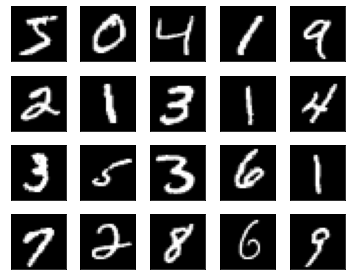

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size)) 

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()  

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

In [14]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 4.2337 Generator Loss: 0.0285
Epoch:  2/100 Discriminator Loss: 6.7684 Generator Loss: 0.0013
Epoch:  3/100 Discriminator Loss: 6.8558 Generator Loss: 0.0013
Epoch:  4/100 Discriminator Loss: 3.3575 Generator Loss: 0.6916
Epoch:  5/100 Discriminator Loss: 4.7679 Generator Loss: 0.1917
Epoch:  6/100 Discriminator Loss: 6.1486 Generator Loss: 1.6935
Epoch:  7/100 Discriminator Loss: 4.4424 Generator Loss: 0.7184
Epoch:  8/100 Discriminator Loss: 0.8908 Generator Loss: 4.1279
Epoch:  9/100 Discriminator Loss: 2.5241 Generator Loss: 1.4697
Epoch: 10/100 Discriminator Loss: 2.6938 Generator Loss: 3.3556


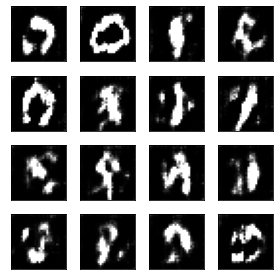

Epoch: 11/100 Discriminator Loss: 7.6918 Generator Loss: 7.4419
Epoch: 12/100 Discriminator Loss: 2.0505 Generator Loss: 1.0040
Epoch: 13/100 Discriminator Loss: 1.5305 Generator Loss: 0.5485
Epoch: 14/100 Discriminator Loss: 3.2818 Generator Loss: 3.7659
Epoch: 15/100 Discriminator Loss: 2.2638 Generator Loss: 2.8940
Epoch: 16/100 Discriminator Loss: 3.1057 Generator Loss: 2.4770
Epoch: 17/100 Discriminator Loss: 1.6202 Generator Loss: 2.0673
Epoch: 18/100 Discriminator Loss: 2.7407 Generator Loss: 4.1914
Epoch: 19/100 Discriminator Loss: 1.5783 Generator Loss: 1.4638
Epoch: 20/100 Discriminator Loss: 3.9413 Generator Loss: 5.2345


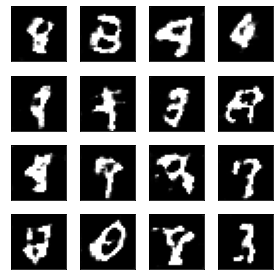

Epoch: 21/100 Discriminator Loss: 1.4537 Generator Loss: 2.8991
Epoch: 22/100 Discriminator Loss: 4.4071 Generator Loss: 5.5361
Epoch: 23/100 Discriminator Loss: 3.6313 Generator Loss: 4.4595
Epoch: 24/100 Discriminator Loss:24.2695 Generator Loss:25.5594
Epoch: 25/100 Discriminator Loss: 3.6390 Generator Loss: 5.0332
Epoch: 26/100 Discriminator Loss: 1.9769 Generator Loss: 3.2923
Epoch: 27/100 Discriminator Loss: 3.8777 Generator Loss: 2.8423
Epoch: 28/100 Discriminator Loss: 1.7453 Generator Loss: 1.2303
Epoch: 29/100 Discriminator Loss: 1.9753 Generator Loss: 2.0196
Epoch: 30/100 Discriminator Loss: 1.8539 Generator Loss: 2.7811


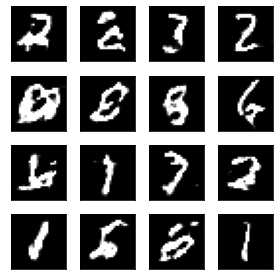

Epoch: 31/100 Discriminator Loss: 2.3869 Generator Loss: 3.1820
Epoch: 32/100 Discriminator Loss: 2.2272 Generator Loss: 3.3163
Epoch: 33/100 Discriminator Loss: 2.4824 Generator Loss: 2.4677
Epoch: 34/100 Discriminator Loss: 3.0637 Generator Loss: 3.9945
Epoch: 35/100 Discriminator Loss: 2.6259 Generator Loss: 3.7804
Epoch: 36/100 Discriminator Loss: 2.5548 Generator Loss: 3.1894
Epoch: 37/100 Discriminator Loss: 3.2926 Generator Loss: 4.2942
Epoch: 38/100 Discriminator Loss: 2.6723 Generator Loss: 3.0537
Epoch: 39/100 Discriminator Loss: 2.1590 Generator Loss: 2.8269
Epoch: 40/100 Discriminator Loss: 2.4105 Generator Loss: 3.5332


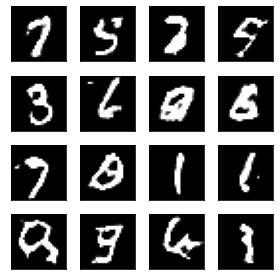

Epoch: 41/100 Discriminator Loss: 2.5495 Generator Loss: 2.3683
Epoch: 42/100 Discriminator Loss: 2.1692 Generator Loss: 3.2534
Epoch: 43/100 Discriminator Loss: 2.5532 Generator Loss: 3.7723
Epoch: 44/100 Discriminator Loss: 5.0403 Generator Loss: 5.8434
Epoch: 45/100 Discriminator Loss:21.5142 Generator Loss:20.7367
Epoch: 46/100 Discriminator Loss: 4.4643 Generator Loss: 5.4713
Epoch: 47/100 Discriminator Loss: 4.0181 Generator Loss: 5.3729
Epoch: 48/100 Discriminator Loss: 1.8196 Generator Loss: 2.5136
Epoch: 49/100 Discriminator Loss: 1.6500 Generator Loss: 1.7155
Epoch: 50/100 Discriminator Loss: 1.9388 Generator Loss: 2.5498


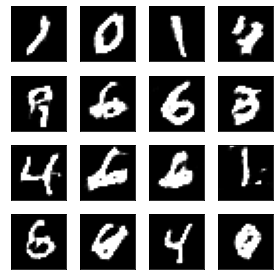

Epoch: 51/100 Discriminator Loss: 1.7668 Generator Loss: 2.4084
Epoch: 52/100 Discriminator Loss: 2.2492 Generator Loss: 3.2447
Epoch: 53/100 Discriminator Loss: 3.3355 Generator Loss: 3.3986
Epoch: 54/100 Discriminator Loss: 2.0549 Generator Loss: 2.5290
Epoch: 55/100 Discriminator Loss: 2.0580 Generator Loss: 2.3381
Epoch: 56/100 Discriminator Loss: 2.1621 Generator Loss: 3.8254
Epoch: 57/100 Discriminator Loss: 3.1475 Generator Loss: 4.3087
Epoch: 58/100 Discriminator Loss: 5.0516 Generator Loss: 5.6800
Epoch: 59/100 Discriminator Loss: 2.6878 Generator Loss: 4.0195
Epoch: 60/100 Discriminator Loss: 2.3392 Generator Loss: 3.0525


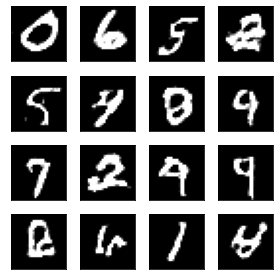

Epoch: 61/100 Discriminator Loss: 2.8371 Generator Loss: 3.3505
Epoch: 62/100 Discriminator Loss: 2.3309 Generator Loss: 3.2168
Epoch: 63/100 Discriminator Loss: 1.2913 Generator Loss: 1.8707
Epoch: 64/100 Discriminator Loss: 3.9801 Generator Loss: 4.0863
Epoch: 65/100 Discriminator Loss: 8.4797 Generator Loss: 4.4842
Epoch: 66/100 Discriminator Loss: 1.8910 Generator Loss: 3.3591
Epoch: 67/100 Discriminator Loss: 3.9974 Generator Loss: 3.9939
Epoch: 68/100 Discriminator Loss: 1.6032 Generator Loss: 3.8902
Epoch: 69/100 Discriminator Loss: 2.6669 Generator Loss: 2.8639
Epoch: 70/100 Discriminator Loss: 1.2884 Generator Loss: 1.3834


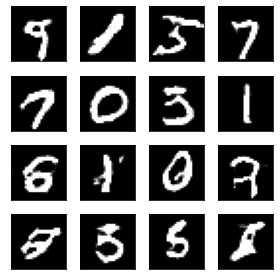

Epoch: 71/100 Discriminator Loss: 3.4266 Generator Loss: 3.9646
Epoch: 72/100 Discriminator Loss: 2.8057 Generator Loss: 4.3430
Epoch: 73/100 Discriminator Loss: 2.6812 Generator Loss: 3.5085
Epoch: 74/100 Discriminator Loss: 3.9818 Generator Loss: 3.9881
Epoch: 75/100 Discriminator Loss: 2.2883 Generator Loss: 3.1227
Epoch: 76/100 Discriminator Loss: 1.3930 Generator Loss: 1.6848
Epoch: 77/100 Discriminator Loss: 8.4210 Generator Loss: 8.9621
Epoch: 78/100 Discriminator Loss: 4.1028 Generator Loss: 5.3525
Epoch: 79/100 Discriminator Loss: 2.6963 Generator Loss: 3.5219
Epoch: 80/100 Discriminator Loss: 2.4825 Generator Loss: 3.0952


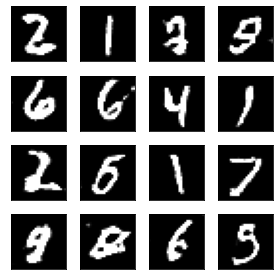

Epoch: 81/100 Discriminator Loss: 3.2420 Generator Loss: 3.8740
Epoch: 82/100 Discriminator Loss: 2.6417 Generator Loss: 2.6829
Epoch: 83/100 Discriminator Loss: 3.5658 Generator Loss: 4.9340
Epoch: 84/100 Discriminator Loss: 4.5053 Generator Loss: 4.1165
Epoch: 85/100 Discriminator Loss: 1.7484 Generator Loss: 1.4617
Epoch: 86/100 Discriminator Loss: 5.0671 Generator Loss: 6.1670
Epoch: 87/100 Discriminator Loss: 4.5042 Generator Loss: 5.5070
Epoch: 88/100 Discriminator Loss: 1.3540 Generator Loss: 3.1674
Epoch: 89/100 Discriminator Loss: 0.7884 Generator Loss: 1.4366
Epoch: 90/100 Discriminator Loss: 1.8240 Generator Loss: 2.5879


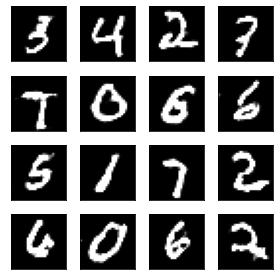

Epoch: 91/100 Discriminator Loss: 3.0293 Generator Loss: 3.3380
Epoch: 92/100 Discriminator Loss: 3.5623 Generator Loss: 4.7543
Epoch: 93/100 Discriminator Loss: 4.6982 Generator Loss: 5.2062
Epoch: 94/100 Discriminator Loss: 2.6887 Generator Loss: 3.5786
Epoch: 95/100 Discriminator Loss: 6.6884 Generator Loss: 7.2367
Epoch: 96/100 Discriminator Loss: 3.7075 Generator Loss: 5.1347
Epoch: 97/100 Discriminator Loss: 5.0678 Generator Loss: 5.7923
Epoch: 98/100 Discriminator Loss: 3.7310 Generator Loss: 4.6721
Epoch: 99/100 Discriminator Loss: 5.3339 Generator Loss: 5.6876
Epoch:100/100 Discriminator Loss: 3.9544 Generator Loss: 4.0112


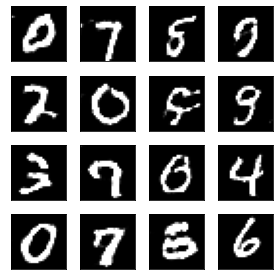

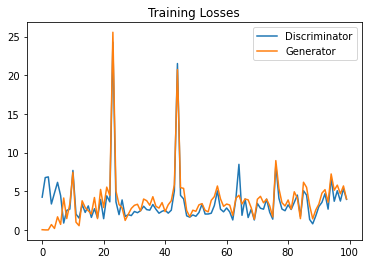

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.01);

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 7.7881 Generator Loss: 0.0009
Epoch:  2/100 Discriminator Loss:31.7795 Generator Loss: 0.0000
Epoch:  3/100 Discriminator Loss:21.4486 Generator Loss: 0.0000
Epoch:  4/100 Discriminator Loss:14.2034 Generator Loss: 1.1738
Epoch:  5/100 Discriminator Loss:12.0977 Generator Loss: 0.3851
Epoch:  6/100 Discriminator Loss:35.2919 Generator Loss: 0.0016
Epoch:  7/100 Discriminator Loss:37.9663 Generator Loss: 0.3191
Epoch:  8/100 Discriminator Loss:44.4643 Generator Loss: 0.0430
Epoch:  9/100 Discriminator Loss:39.5947 Generator Loss: 0.1326
Epoch: 10/100 Discriminator Loss:30.0804 Generator Loss: 0.0328


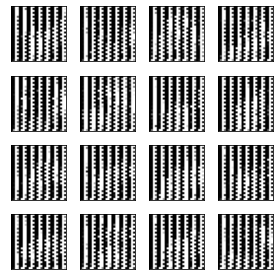

Epoch: 11/100 Discriminator Loss:21.3005 Generator Loss: 0.0921
Epoch: 12/100 Discriminator Loss:19.0044 Generator Loss: 1.9267
Epoch: 13/100 Discriminator Loss: 2.5124 Generator Loss: 4.3205
Epoch: 14/100 Discriminator Loss: 1.8903 Generator Loss: 1.8592
Epoch: 15/100 Discriminator Loss: 4.3552 Generator Loss: 5.0420
Epoch: 16/100 Discriminator Loss: 1.7844 Generator Loss: 1.3304
Epoch: 17/100 Discriminator Loss: 4.0643 Generator Loss: 4.9811
Epoch: 18/100 Discriminator Loss: 5.0572 Generator Loss: 6.4450
Epoch: 19/100 Discriminator Loss: 2.0079 Generator Loss: 2.3161
Epoch: 20/100 Discriminator Loss: 5.3375 Generator Loss: 6.7992


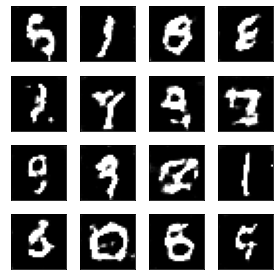

Epoch: 21/100 Discriminator Loss: 3.6078 Generator Loss: 4.3222
Epoch: 22/100 Discriminator Loss: 3.4477 Generator Loss: 5.5317
Epoch: 23/100 Discriminator Loss: 2.7096 Generator Loss: 4.3086
Epoch: 24/100 Discriminator Loss: 0.9916 Generator Loss: 0.9625
Epoch: 25/100 Discriminator Loss: 4.6853 Generator Loss: 6.1873
Epoch: 26/100 Discriminator Loss: 3.6099 Generator Loss: 5.4561
Epoch: 27/100 Discriminator Loss: 6.5805 Generator Loss: 5.5115
Epoch: 28/100 Discriminator Loss: 2.7297 Generator Loss: 4.5502
Epoch: 29/100 Discriminator Loss: 3.8414 Generator Loss: 3.9547
Epoch: 30/100 Discriminator Loss: 2.7560 Generator Loss: 2.3841


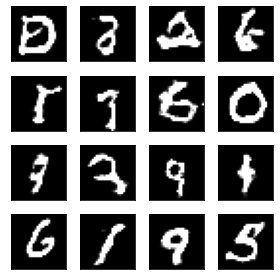

Epoch: 31/100 Discriminator Loss: 4.5326 Generator Loss: 3.3672
Epoch: 32/100 Discriminator Loss: 9.9595 Generator Loss: 8.3453
Epoch: 33/100 Discriminator Loss: 5.2935 Generator Loss: 3.7435
Epoch: 34/100 Discriminator Loss: 3.3588 Generator Loss: 1.2324
Epoch: 35/100 Discriminator Loss: 4.6576 Generator Loss: 2.8529
Epoch: 36/100 Discriminator Loss: 2.3756 Generator Loss: 3.0798
Epoch: 37/100 Discriminator Loss: 3.9755 Generator Loss: 3.9162
Epoch: 38/100 Discriminator Loss: 4.0400 Generator Loss: 4.4138
Epoch: 39/100 Discriminator Loss: 4.2047 Generator Loss: 2.4497
Epoch: 40/100 Discriminator Loss: 3.7854 Generator Loss: 3.5498


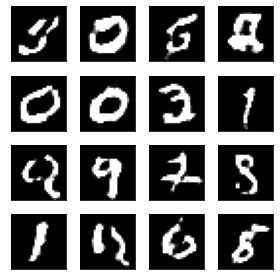

Epoch: 41/100 Discriminator Loss: 5.2578 Generator Loss: 0.8896
Epoch: 42/100 Discriminator Loss: 4.7594 Generator Loss: 0.2774
Epoch: 43/100 Discriminator Loss: 8.5257 Generator Loss: 6.3715
Epoch: 44/100 Discriminator Loss: 1.7271 Generator Loss: 3.5143
Epoch: 45/100 Discriminator Loss: 4.2192 Generator Loss: 3.7354
Epoch: 46/100 Discriminator Loss:10.5256 Generator Loss: 9.7633
Epoch: 47/100 Discriminator Loss: 8.9247 Generator Loss: 8.6137
Epoch: 48/100 Discriminator Loss: 7.7617 Generator Loss: 7.5826
Epoch: 49/100 Discriminator Loss:13.3617 Generator Loss:11.0618
Epoch: 50/100 Discriminator Loss: 7.5162 Generator Loss: 5.5509


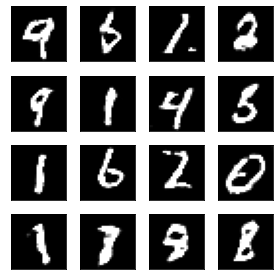

Epoch: 51/100 Discriminator Loss: 4.3091 Generator Loss: 2.6594
Epoch: 52/100 Discriminator Loss: 4.7234 Generator Loss: 5.7357
Epoch: 53/100 Discriminator Loss: 3.1150 Generator Loss: 1.9879
Epoch: 54/100 Discriminator Loss: 4.0461 Generator Loss: 3.9000
Epoch: 55/100 Discriminator Loss:16.0243 Generator Loss:16.3938
Epoch: 56/100 Discriminator Loss: 4.8684 Generator Loss: 5.0912
Epoch: 57/100 Discriminator Loss: 8.7878 Generator Loss:11.0360
Epoch: 58/100 Discriminator Loss: 9.9349 Generator Loss:10.7982
Epoch: 59/100 Discriminator Loss: 4.9738 Generator Loss: 5.3011
Epoch: 60/100 Discriminator Loss: 6.0319 Generator Loss: 6.6081


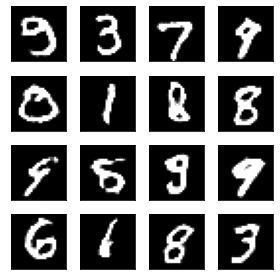

Epoch: 61/100 Discriminator Loss: 4.9745 Generator Loss: 5.8955
Epoch: 62/100 Discriminator Loss: 4.6466 Generator Loss: 5.0841
Epoch: 63/100 Discriminator Loss: 3.6392 Generator Loss: 2.9458
Epoch: 64/100 Discriminator Loss: 9.4388 Generator Loss: 7.6886
Epoch: 65/100 Discriminator Loss: 4.8012 Generator Loss: 4.7917
Epoch: 66/100 Discriminator Loss: 6.0384 Generator Loss: 6.0226
Epoch: 67/100 Discriminator Loss: 6.7673 Generator Loss: 5.6295
Epoch: 68/100 Discriminator Loss: 3.3810 Generator Loss: 3.4823
Epoch: 69/100 Discriminator Loss: 6.4606 Generator Loss: 5.4069
Epoch: 70/100 Discriminator Loss:12.2775 Generator Loss:10.5300


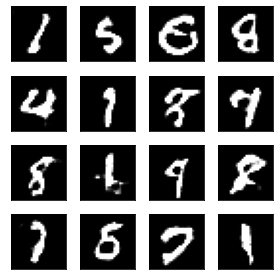

Epoch: 71/100 Discriminator Loss: 7.5920 Generator Loss: 8.4650
Epoch: 72/100 Discriminator Loss: 9.4846 Generator Loss: 7.1104
Epoch: 73/100 Discriminator Loss: 3.7581 Generator Loss: 3.6320
Epoch: 74/100 Discriminator Loss: 8.4693 Generator Loss: 6.3210
Epoch: 75/100 Discriminator Loss: 6.3821 Generator Loss: 7.0101
Epoch: 76/100 Discriminator Loss: 5.7378 Generator Loss: 5.2931
Epoch: 77/100 Discriminator Loss: 6.2837 Generator Loss: 6.9378
Epoch: 78/100 Discriminator Loss: 7.7591 Generator Loss: 6.4955
Epoch: 79/100 Discriminator Loss: 4.5082 Generator Loss: 4.3808
Epoch: 80/100 Discriminator Loss: 5.6209 Generator Loss: 5.0692


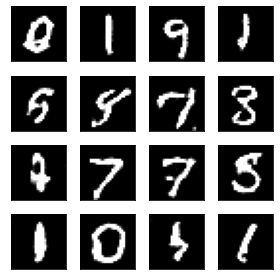

Epoch: 81/100 Discriminator Loss: 7.3626 Generator Loss: 7.5657
Epoch: 82/100 Discriminator Loss: 3.4800 Generator Loss: 4.4357
Epoch: 83/100 Discriminator Loss: 8.2607 Generator Loss: 9.1844
Epoch: 84/100 Discriminator Loss: 9.8269 Generator Loss:11.5834
Epoch: 85/100 Discriminator Loss:10.7013 Generator Loss:10.6570
Epoch: 86/100 Discriminator Loss: 7.2639 Generator Loss: 8.0355
Epoch: 87/100 Discriminator Loss: 9.6350 Generator Loss:11.1082
Epoch: 88/100 Discriminator Loss:13.7630 Generator Loss:12.9303
Epoch: 89/100 Discriminator Loss:13.8185 Generator Loss:10.1318
Epoch: 90/100 Discriminator Loss:10.9192 Generator Loss:12.1151


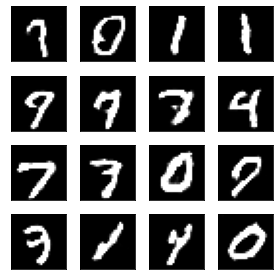

Epoch: 91/100 Discriminator Loss: 4.9048 Generator Loss: 7.9779
Epoch: 92/100 Discriminator Loss: 8.8764 Generator Loss: 8.5839
Epoch: 93/100 Discriminator Loss: 8.7157 Generator Loss: 5.9605
Epoch: 94/100 Discriminator Loss:11.1633 Generator Loss:11.2805
Epoch: 95/100 Discriminator Loss:11.5056 Generator Loss:14.9631
Epoch: 96/100 Discriminator Loss: 3.8688 Generator Loss: 5.0088
Epoch: 97/100 Discriminator Loss: 5.3748 Generator Loss: 4.2500
Epoch: 98/100 Discriminator Loss: 5.3893 Generator Loss: 5.9558
Epoch: 99/100 Discriminator Loss: 4.6207 Generator Loss: 3.5849
Epoch:100/100 Discriminator Loss: 8.8707 Generator Loss: 0.7971


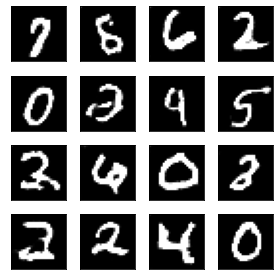

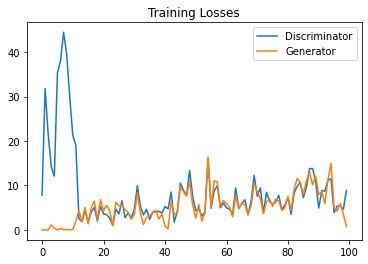

In [16]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);